# Is a solar system target visible from a given site?

Uses astropy, astroplan, and sbpy to get information from Horizons about where a target is on the sky, how bright it is, and then whether it is visible at a given observatory at that time (more information about airmass, etc.). 

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from astroplan import Observer
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroplan.plots import plot_airmass, plot_altitude
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)
from astroplan import is_observable

from sbpy.data import Ephem

This can be useful to know which site names are available. 

In [2]:
from astropy.coordinates import EarthLocation

site_names = EarthLocation.get_site_names()

[s for s in site_names if "Siding" in s]

['Siding Spring Observatory']

Set up site information and time range and target name - query for ephemerides from JPL Horizons.
Add a magnitude cutoff to limit dates/times of interest.

In [79]:
# Set up observer, target, and time
site_name = "Cerro Pachon"
location = EarthLocation.of_site(site_name)
observer = Observer.at_site(site_name)

target = 'C/2023 P1'

epochs = {'start': Time('2022-01-01'),
          'stop': Time('2023-08-20'),
          'step': 15 * u.day}

eph = Ephem.from_horizons(target, location=location, epochs=epochs)
# eph.field_names
magcol = 'Tmag'  # 'V' for asteroids

# Add a brightness cutoff 
magcutoff = 22 * u.mag
bright = np.where(eph[magcol] < magcutoff)

ss_vis = eph['epoch', 'rh', 'delta', 'ra', 'dec', 'RA*cos(Dec)_rate', 'DEC_rate', magcol][bright]

ss_vis

<QTable length=18>
  epoch         r             delta           RA      DEC    RA*cos(Dec)_rate  DEC_rate    Tmag 
                AU              AU           deg      deg       arcsec / h    arcsec / h   mag  
   Time      float64         float64       float64  float64      float64       float64   float64
--------- -------------- ---------------- --------- -------- ---------------- ---------- -------
2459910.5 5.112143309124 4.38008204247877  98.83542 -8.35529         -28.8817   -7.38647  21.793
2459925.5 4.916250226494 4.08462665060526  95.45972 -8.90244         -37.4914   -3.27098  21.472
2459940.5 4.717862930506 3.85895827431831  91.34994 -8.95902         -43.2711   2.381125   21.17
2459955.5 4.516778945671 3.70941357686239  86.89846 -8.40972         -44.4308   8.668699  20.895
2459970.5  4.31276609398 3.63210764095647  82.60855 -7.25077         -40.5181   14.41679  20.648
2459985.5 4.105556324809  3.6133646521787  78.95574 -5.59159         -32.5136   18.58226  20.423
2460000.5 3

For a first pass at whether or not a target would be visible at this site .. these limits are pretty loose and the resulting "observable" value just tells you whether or not the timestep has *any* observability option. 

In [83]:
constraints = [AltitudeConstraint(15*u.deg, 85*u.deg),
               AirmassConstraint(4.5), AtNightConstraint.twilight_astronomical()]

observable = []
year = []
for days, ra, dec in zip(ss_vis['epoch'], ss_vis['ra'], ss_vis['dec']):
    fields = [SkyCoord(ra, dec, frame="icrs")]
    time_range = [days, days + epochs['step']]

    # Are targets *ever* observable in the time range?
    observable.append(is_observable(constraints, observer, fields, time_range=time_range))
    year.append(days.isot.split('T')[0])
    
ss_vis['observable'] = observable
ss_vis['year'] = year

ss_vis['year', 'RA', 'DEC', 'Tmag', 'observable']

<QTable length=18>
   year        RA      DEC      Tmag  observable
              deg      deg      mag             
  str10     float64  float64  float64  bool[1]  
---------- --------- -------- ------- ----------
2022-11-27  98.83542 -8.35529  21.793       True
2022-12-12  95.45972 -8.90244  21.472       True
2022-12-27  91.34994 -8.95902   21.17       True
2023-01-11  86.89846 -8.40972  20.895       True
2023-01-26  82.60855 -7.25077  20.648       True
2023-02-10  78.95574 -5.59159  20.423       True
2023-02-25  76.24723 -3.60585  20.206       True
2023-03-12  74.60554 -1.46545  19.981       True
2023-03-27  74.00419  0.70122  19.731       True
2023-04-11  74.34536  2.81224  19.444       True
2023-04-26  75.50879  4.82842  19.105       True
2023-05-11  77.38385  6.73584  18.702      False
2023-05-26  79.89092  8.54439   18.22      False
2023-06-10    82.986 10.28007  17.639      False
2023-06-25  86.69201 11.99458   16.93      False
2023-07-10  91.12859 13.77568  16.051      False
2

For each of those dates, look more carefully at the target visibility. This can be a lot of plots .. 

sunset: 2023-08-08T22:10:03.583
sunrise: 2023-08-09T11:26:37.915
middle: 2023-08-09T04:48:20.749
target rise time: 2023-08-09T09:15:12.851
target set time: 2023-08-08T19:48:34.150


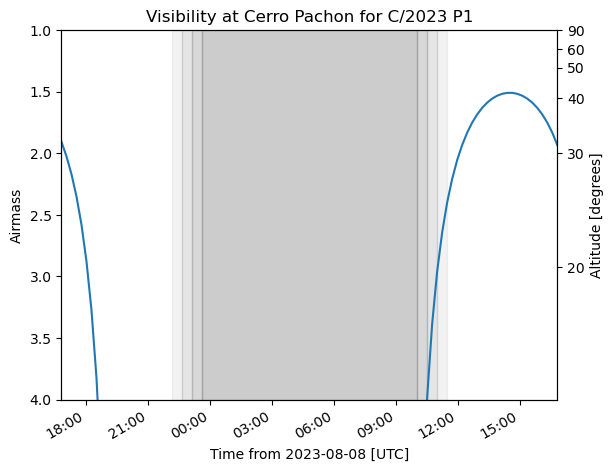

In [86]:
idx = np.where(ss_vis['year'] == '2023-08-09') 
subset = ss_vis[idx]

for days, ra, dec in zip(subset['epoch'], subset['ra'], subset['dec']):
    sunset = site.sun_set_time(days)
    sunrise = site.sun_rise_time(days, which='next')

    print('sunset:', sunset.isot)
    print('sunrise:', sunrise.isot)
    observe_time = (sunrise - sunset)/2.0 + sunset
    print('middle:', observe_time.isot)

    field = SkyCoord(ra, dec, frame="icrs")

    rise_time = site.target_rise_time(observe_time, field)
    print('target rise time:', rise_time.isot)
    set_time = site.target_set_time(observe_time, field)
    print('target set time:', set_time.isot)

    plot_airmass(field, site, observe_time, brightness_shading=True,
                altitude_yaxis=True, max_airmass=4)
    plt.title(f"Visibility at {site.name} for {target}")
    plt.show()